## 1. Charger et Explorer CK+
#### 1.1 Vérifier la Structure des Dossiers

Les images sont stockées dans des dossiers nommés d'après les émotions (anger, contempt, disgust, fear, happy, sadness, surprise). On va :

-Lister les classes disponibles.

-Compter le nombre d'images par classe.

-Afficher quelques images pour visualiser les données.

Classes d'émotions : ['anger', 'contempt', 'disgust', 'fear', 'happy', 'sadness', 'surprise']
anger: 135 images
contempt: 54 images
disgust: 177 images
fear: 75 images
happy: 207 images
sadness: 84 images
surprise: 249 images


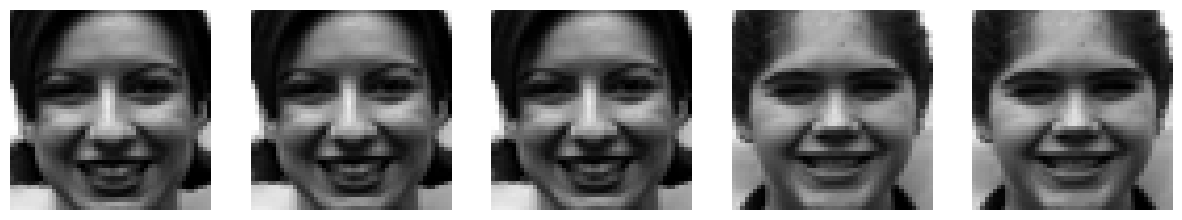

In [ ]:
import os
import matplotlib.pyplot as plt
import cv2
import numpy as np

# Définir le chemin vers le dataset CK+
dataset_path = "projetcomputervision/emotions"

# Lister les classes d'émotions
classes = os.listdir(dataset_path)
print("Classes d'émotions :", classes)

# Compter le nombre d'images par classe
for emotion in classes:
    path = os.path.join(dataset_path, emotion)
    print(f"{emotion}: {len(os.listdir(path))} images")

# Afficher quelques images
def show_sample_images(emotion, num_images=5):
    emotion_path = os.path.join(dataset_path, emotion)
    images = os.listdir(emotion_path)[:num_images]

    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))
    for i, img_name in enumerate(images):
        img_path = os.path.join(emotion_path, img_name)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        axes[i].imshow(img, cmap='gray')
        axes[i].axis('off')
    plt.show()

# Exemple : afficher des images de la classe "happy" (heureux)
show_sample_images("happy")


#### 1.2 Détection et Recadrage des Visages
Les images de CK+ peuvent contenir des visages avec du bruit autour. On utilise OpenCV ou MTCNN pour détecter et extraire uniquement les visages.

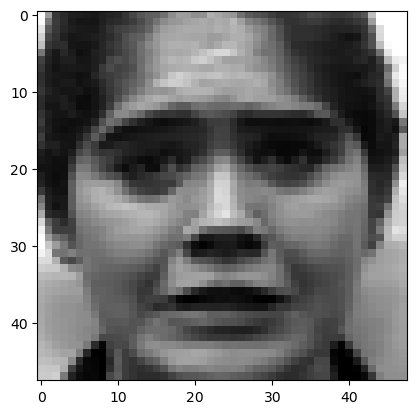

In [50]:
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

def detect_face(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    faces = face_cascade.detectMultiScale(img, scaleFactor=1.3, minNeighbors=5)

    for (x, y, w, h) in faces:
        return img[y:y+h, x:x+w]  # Retourne le visage détecté
    return img  # Si pas de visage, retourne l’image originale

# Tester avec une image
image_path = os.path.join(dataset_path, "fear", os.listdir(os.path.join(dataset_path, "fear"))[0])
face = detect_face(image_path)
plt.imshow(face, cmap='gray')
plt.show()


# 1.3 Prétraitement de l'Image
Ce code redimensionne l'image à 224x224 pixels et la normalise en divisant les valeurs des pixels par 255 pour les ramener dans la plage [0, 1]. Cela permet de préparer l'image pour l'entrée dans un modèle de Deep Learning.

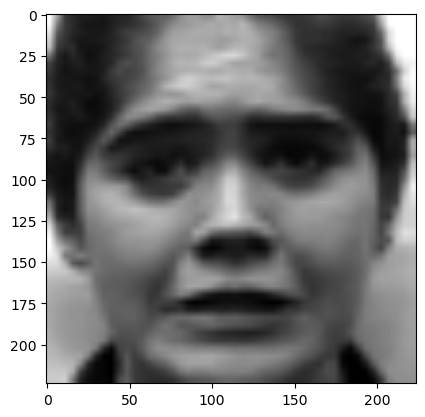

In [53]:
def preprocess_image(img):
    img = cv2.resize(img, (224, 224))  # Redimensionnement
    img = img / 255.0  # Normalisation
    return img

preprocessed_img = preprocess_image(face)
plt.imshow(preprocessed_img, cmap='gray')
plt.show()


#### 1.3 Alignement des Visages
L’alignement permet de normaliser la position des yeux pour une meilleure reconnaissance. On utilise dlib pour détecter les points clés et ajuster l’image.

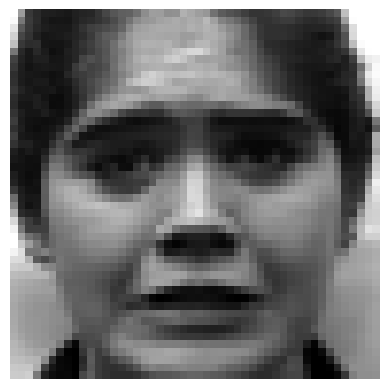

In [56]:
# Fonction d'alignement du visage
def align_face(img):
    # Détecter les visages
    faces = face_cascade.detectMultiScale(img, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    # Si un visage est détecté
    if len(faces) > 0:
        (x, y, w, h) = faces[0]  # On prend le premier visage détecté
        face = img[y:y+h, x:x+w]  # Extraire la région du visage

        # Détecter les yeux dans la région du visage
        eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')
        eyes = eye_cascade.detectMultiScale(face)

        if len(eyes) >= 2:  # Assurer qu'il y a au moins deux yeux détectés
            # Extraire les coordonnées des deux premiers yeux détectés
            (ex1, ey1, ew1, eh1) = eyes[0]
            (ex2, ey2, ew2, eh2) = eyes[1]

            # Calculer l'angle entre les yeux
            eye_center = ((ex1 + ex2 + ew1 + ew2) / 2, (ey1 + ey2 + eh1 + eh2) / 2)
            dx, dy = ex2 - ex1, ey2 - ey1
            angle = np.degrees(np.arctan2(dy, dx))

            # Calculer la matrice de rotation pour aligner les yeux horizontalement
            M = cv2.getRotationMatrix2D(eye_center, angle, 1)
            aligned_face = cv2.warpAffine(face, M, (face.shape[1], face.shape[0]))

            return aligned_face

    # Si aucun visage n'est trouvé, retourner l'image originale
    return img

# Appliquer l'alignement à l'image détectée
aligned_face = align_face(face)

# Afficher l'image alignée
plt.imshow(aligned_face, cmap='gray')  # Afficher l'image alignée en niveaux de gris
plt.axis('off')
plt.show()

## 2- Modèles de reconnaissance des expressions faciales
#### 2.1- Prétraitement des images du dataset pour la classification des expressions faciales avec CNN

In [59]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Define paths and emotions
emotions = {0: "anger", 1: "disgust", 2: "fear", 3: "happy", 4: "sadness", 5: "surprise", 6: "contempt"}
data_path = "projetcomputervision/emotions"  # Replace with the path to your CK+ dataset

# Load images and labels
images = []
labels = []

for emotion, emotion_name in emotions.items():
    emotion_folder = os.path.join(data_path, emotion_name)
    for image_name in os.listdir(emotion_folder):
        image_path = os.path.join(emotion_folder, image_name)
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Read as grayscale
        image = cv2.resize(image, (48, 48))  # Resize to 48x48
        images.append(image)
        labels.append(emotion)

# Convert to numpy arrays
images = np.array(images, dtype="float32") / 255.0  # Normalize pixel values
labels = np.array(labels)

# One-hot encode labels
labels = to_categorical(labels, num_classes=len(emotions))

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

# Reshape images for CNN input
X_train = X_train.reshape(-1, 48, 48, 1)
X_test = X_test.reshape(-1, 48, 48, 1)

#### 2.2- Modélisation et entraînement d'un CNN pour la reconnaissance des expressions faciales

In [62]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Define the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation="relu", input_shape=(48, 48, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation="relu"),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation="relu"),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation="relu"),
    Dropout(0.5),
    Dense(len(emotions), activation="softmax")
])

# Compile the model
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Train the model
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

# Save the model
model.save("emotion_detection_model.h5")

Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - accuracy: 0.2468 - loss: 1.8737 - val_accuracy: 0.4162 - val_loss: 1.8378
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - accuracy: 0.3024 - loss: 1.8103 - val_accuracy: 0.6193 - val_loss: 1.6930
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.4155 - loss: 1.5773 - val_accuracy: 0.5939 - val_loss: 1.1940
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.5673 - loss: 1.1843 - val_accuracy: 0.6294 - val_loss: 0.9369
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.6254 - loss: 1.0167 - val_accuracy: 0.6751 - val_loss: 0.8326
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.6877 - loss: 0.7752 - val_accuracy: 0.7462 - val_loss: 0.7053
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.7285 - loss: 0.7398 - val_accuracy: 0.8173 - val_loss: 0.5656
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.7278 - loss: 0.6982 - val_accuracy: 0.8071 - v

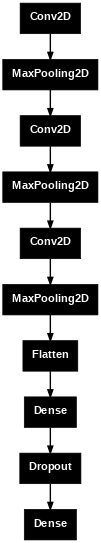

In [6]:
from tensorflow.keras.utils import plot_model
plot_model(model, dpi=50)

#### 2.3- Reconnaissance Faciale des Émotions en Temps Réel

In [65]:
import cv2
from tensorflow.keras.models import load_model

# Load the trained model
model = load_model("emotion_detection_model.h5")

# Initialize OpenCV's face detector
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")

# Start video capture
cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Convert frame to grayscale
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Detect faces
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    for (x, y, w, h) in faces:
        # Extract the face ROI
        face_roi = gray[y:y+h, x:x+w]
        face_roi = cv2.resize(face_roi, (48, 48))
        face_roi = face_roi.reshape(1, 48, 48, 1) / 255.0  # Preprocess for the model

        # Predict emotion
        prediction = model.predict(face_roi)
        emotion = emotions[np.argmax(prediction)]

        # Draw rectangle and label
        cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
        cv2.putText(frame, emotion, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

    # Display the frame
    cv2.imshow("Real-Time Emotion Detection", frame)

    # Break the loop on 'q' key press
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release resources
cap.release()
cv2.destroyAllWindows()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━

#### 2.4- Prédiction d'Émotions à partir d'une Image avec un Modèle CNN

In [70]:
image_path = "Happy_face.png"  # Remplace par le chemin de ton image
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Charger en niveau de gris
if image is None:
    print("Erreur : Image introuvable.")
else:
    # Prétraitement de l'image
    image = cv2.resize(image, (48, 48))  # Redimensionner à 48x48
    image = image.reshape(1, 48, 48, 1) / 255.0  # Normaliser et changer la forme

    # Prédire l'émotion
    prediction = model.predict(image)
    emotion = emotions[int(np.argmax(prediction))]

    print(f"L'émotion prédite est : {emotion}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
L'émotion prédite est : happy
